In [53]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# Directory containing your CSV files
folder_path = '/Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Batch size
batch_size = 34

# Function for timestamp comparison
def compare_timestamps(var1, var2):
  try:
    timestamp1 = int(var1.split("_")[0])
    timestamp2 = int(var2.split("_")[0])
  except ValueError:
    return False
  threshold = 1  # You can adjust this threshold as needed
  return abs(timestamp1 - timestamp2) <= threshold

batch_wise_results = []

# Loop through files in batches
for start_index in range(0, len(csv_files), batch_size):
  # Get current batch of files
  batch_files = csv_files[start_index:start_index + batch_size]

  # Initialize common columns
  common_columns = set(pd.read_csv(os.path.join(folder_path, batch_files[0])).columns)

  # Find common columns within the batch
  for csv_file in batch_files[1:]:
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    common_columns = common_columns.intersection(df.columns)
    
  # Check if common variables are less than 5, skip the batch
  if len(common_columns) < 5:
    print(f"\nSkipping Batch {start_index // batch_size + 1} (Less than 5 common variables):")
    for file in batch_files:
      print(f"- {file}")
    continue

  # Print common variables for this batch
  print(f"\nCommon Variables (Batch {start_index // batch_size + 1}):")
  print(common_columns)

  # Initialize all columns
  all_columns = set()

  # Find all unique columns within the batch
  for csv_file in batch_files:
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    all_columns.update(df.columns)

  # Find uncommon variables for this batch
  uncommon_variables = all_columns - common_columns
  print(f"\nUncommon Variables (Batch {start_index // batch_size + 1}):")
  print(uncommon_variables)

  # Process data within the batch
  concatenated_data = None
  for idx, csv_file in enumerate(batch_files):
    # Load data from CSV file
    df = pd.read_csv(os.path.join(folder_path, csv_file))[list(common_columns) + ['precipitationCal']]

    # Extract features (X) and target (y) from the data
    X = df.drop(columns=['precipitationCal'])
    y = df['precipitationCal']

    # Ensure y contains only one column
    if isinstance(y, pd.DataFrame):
      y = y.values.reshape(-1)
      y = y[:len(X)]

    # Reshape X for LSTM input
    X = X.values.reshape(X.shape[0], 1, X.shape[1])

    # Initialize the model (can be moved outside the loop if desired for efficiency)
    model = Sequential()
    model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Output layer

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model on the new data
    model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)
    
    # Concatenate data for all iterations
    concatenated_data = pd.concat([concatenated_data, df], ignore_index=True)

    # Concatenate data for test set if first iteration
    if idx == 0:
      concatenated_data = df.copy()
    else:
      concatenated_data = pd.concat([concatenated_data, df], ignore_index=True)

  # Print processed files
  print(f"\nProcessed files: {batch_files}")

# After processing all batches, prepare and evaluate the test set

# Extract features (X_test) and target (y_test) from concatenated data
X_test = concatenated_data.drop(columns=['precipitationCal'])
y_test = concatenated_data['precipitationCal']

if isinstance(y_test, pd.DataFrame):
  y_test = y_test.values.reshape(-1)
  y_test = y_test[:len(X_test)]

# Reshape X_test for LSTM input
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print expected error (ground truth)
print(f"\nExpected Error (Ground Truth):\n{y_test[-10:]}")

# Calculate the mean squared error for the testing set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
percent_error = ((np.mean(y_test) -  rmse) / rmse) * 100
print(f"Mean Squared Error on Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on Test Set: {rmse:.4f}")
print(f"Percentage Error on Test Set: {percent_error:.2f}%")

# Save the trained model as a .h5 file
model_filename = 'RNN_model.h5'
model.save(model_filename)
print(f"Model saved as {model_filename}")



Common Variables (Batch 1):
{'Date', '1315 IMG_TIR2', '2315 IMG_TIR2', '1645 IMG_TIR1', '1645 IMG_WV', '0245 IMG_TIR2', '0245 IMG_WV', '0715 IMG_TIR2', '1315 IMG_WV', '1645 IMG_TIR2', '0245 IMG_TIR1', 'latitude', 'precipitationCal', '0715 IMG_WV', '2315 IMG_TIR1', 'longitude', '0715 IMG_TIR1', '1315 IMG_TIR1', '2315 IMG_WV'}

Uncommon Variables (Batch 1):
{'0215 IMG_TIR2', '1045 IMG_WV', '0915 IMG_TIR1', '0115 IMG_TIR1', '0445 IMG_WV', '0815 IMG_WV', '1845 IMG_WV', '1545 IMG_TIR1', '1845 IMG_TIR2', '2245 IMG_TIR2', '0115 IMG_TIR2', '0815 IMG_TIR1', '0515 IMG_TIR1', '0545 IMG_TIR1', '2145 IMG_TIR1', '0645 IMG_TIR2', '1445 IMG_TIR1', '0845 IMG_TIR1', '0145 IMG_WV', '0945 IMG_WV', '0215 IMG_TIR1', '1915 IMG_WV', '1245 IMG_TIR1', '1015 IMG_TIR1', '1045 IMG_TIR2', '1745 IMG_TIR2', '0815 IMG_TIR2', '2345 IMG_TIR1', '2045 IMG_WV', '1615 IMG_WV', '0645 IMG_TIR1', '2145 IMG_TIR2', '1615 IMG_TIR2', '1615 IMG_TIR1', '2345 IMG_TIR2', '1045 IMG_TIR1', '0945 IMG_TIR1', '1915 IMG_TIR2', '0915 IMG_WV

625/625 [==============================] - 0s 786us/step - loss: 2218.3547 - val_loss: 891.3070
Epoch 6/10
625/625 [==============================] - 0s 790us/step - loss: 2218.5527 - val_loss: 991.4450
Epoch 7/10
625/625 [==============================] - 0s 787us/step - loss: 2218.3159 - val_loss: 1038.1899
Epoch 8/10
625/625 [==============================] - 0s 786us/step - loss: 2218.4854 - val_loss: 960.3028
Epoch 9/10
625/625 [==============================] - 0s 789us/step - loss: 2218.2395 - val_loss: 959.8775
Epoch 10/10
625/625 [==============================] - 0s 786us/step - loss: 2218.3982 - val_loss: 1060.6260
Epoch 1/10
625/625 [==============================] - 1s 1ms/step - loss: 95.1692 - val_loss: 38.1800
Epoch 2/10
625/625 [==============================] - 1s 802us/step - loss: 93.3390 - val_loss: 43.4202
Epoch 3/10
625/625 [==============================] - 0s 785us/step - loss: 93.3225 - val_loss: 39.5483
Epoch 4/10
625/625 [==============================] - 0s

625/625 [==============================] - 0s 788us/step - loss: 1458.1108 - val_loss: 610.0257
Epoch 3/10
625/625 [==============================] - 0s 787us/step - loss: 1458.7665 - val_loss: 658.3287
Epoch 4/10
625/625 [==============================] - 0s 784us/step - loss: 1457.9508 - val_loss: 636.1478
Epoch 5/10
625/625 [==============================] - 0s 786us/step - loss: 1458.5322 - val_loss: 711.3256
Epoch 6/10
625/625 [==============================] - 0s 780us/step - loss: 1458.5803 - val_loss: 648.8995
Epoch 7/10
625/625 [==============================] - 0s 783us/step - loss: 1458.5829 - val_loss: 666.3491
Epoch 8/10
625/625 [==============================] - 0s 781us/step - loss: 1458.2040 - val_loss: 653.4357
Epoch 9/10
625/625 [==============================] - 0s 781us/step - loss: 1458.2734 - val_loss: 632.4703
Epoch 10/10
625/625 [==============================] - 0s 777us/step - loss: 1458.4120 - val_loss: 626.2632
Epoch 1/10
625/625 [===========================

625/625 [==============================] - 0s 776us/step - loss: 92.7585 - val_loss: 1237.2611
Epoch 10/10
625/625 [==============================] - 0s 782us/step - loss: 92.7170 - val_loss: 1247.9607
Epoch 1/10
625/625 [==============================] - 1s 1ms/step - loss: 122.0811 - val_loss: 196.2560
Epoch 2/10
625/625 [==============================] - 0s 784us/step - loss: 120.9703 - val_loss: 194.7744
Epoch 3/10
625/625 [==============================] - 0s 786us/step - loss: 120.8635 - val_loss: 197.0565
Epoch 4/10
625/625 [==============================] - 0s 779us/step - loss: 120.9485 - val_loss: 196.7464
Epoch 5/10
625/625 [==============================] - 0s 782us/step - loss: 120.9822 - val_loss: 194.8636
Epoch 6/10
625/625 [==============================] - 0s 781us/step - loss: 120.9534 - val_loss: 195.3156
Epoch 7/10
625/625 [==============================] - 0s 784us/step - loss: 120.9765 - val_loss: 194.4042
Epoch 8/10
625/625 [==============================] - 0s 7

625/625 [==============================] - 0s 781us/step - loss: 87.3876 - val_loss: 6.6438
Epoch 8/10
625/625 [==============================] - 0s 786us/step - loss: 87.3592 - val_loss: 7.0539
Epoch 9/10
625/625 [==============================] - 0s 788us/step - loss: 87.3619 - val_loss: 8.0193
Epoch 10/10
625/625 [==============================] - 0s 782us/step - loss: 87.3708 - val_loss: 7.3469
Epoch 1/10
625/625 [==============================] - 2s 1ms/step - loss: 66.1521 - val_loss: 9.7087
Epoch 2/10
625/625 [==============================] - 0s 791us/step - loss: 66.0096 - val_loss: 11.2238
Epoch 3/10
625/625 [==============================] - 0s 791us/step - loss: 66.0221 - val_loss: 10.3550
Epoch 4/10
625/625 [==============================] - 0s 795us/step - loss: 65.9882 - val_loss: 9.0813
Epoch 5/10
625/625 [==============================] - 0s 787us/step - loss: 65.9947 - val_loss: 12.3058
Epoch 6/10
625/625 [==============================] - 0s 783us/step - loss: 65.992

/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from keras.layers import LSTM, Dense


# Path to the unseen data file
unseen_data_path = '/Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2019/interpolated_insat_on_imerg_20190101.csv'  # Replace with your file path

# Path to the saved model file
model_filename = '/Users/kunalpathak9826/RNN_model.h5'

# Batch size (set to 1 for single file testing)
batch_size = 1

# Function for timestamp comparison (assuming timestamps are not relevant for testing)
def compare_timestamps(var1, var2):
  return True  # Can be removed if timestamps aren't used in unseen data

# Load the trained model
model = load_model(model_filename)

# List to store unseen data predictions
unseen_data_predictions = []

# Load unseen data
df = pd.read_csv(unseen_data_path)

# Required features to include
required_features = ['Date', 'latitude', 'longitude', 'precipitationCal']

# Randomly select 122 additional features
random_features = np.random.choice(df.columns.difference(required_features), size=122, replace=False)

# Combine required and randomly selected features
selected_features = required_features + random_features.tolist()

# Extract selected features from unseen data
X = df[selected_features]

# Get maximum feature length from training data (replace with your calculation)
max_features = 126  # Modify this value based on your training data

# Pad unseen data with zeros if it has fewer features
if X.shape[1] < max_features:
  padding_length = max_features - X.shape[1]
  X = np.pad(X, ((0, 0), (0, padding_length)), mode='constant')

# Reshape for LSTM input (assuming X is a 2D array)
X = X.values.reshape(X.shape[0], 1, X.shape[1])

# Make predictions on unseen data
y_pred_unseen = model.predict(X)

# Calculate MSE (modify for other evaluation metrics if needed)
mse = mean_squared_error(df['precipitationCal'], y_pred_unseen)

# Store predictions and error
unseen_data_predictions.append({'filename': unseen_data_path, 'predictions': y_pred_unseen.squeeze(), 'mse': mse})

# Print unseen data predictions and error
print("Unseen Data Predictions:")
for prediction in unseen_data_predictions:
  print(f"File: {prediction['filename']}, MSE: {prediction['mse']:.4f}")

# You can further save the predictions to a CSV file for later analysis
unseen_predictions_df = pd.DataFrame(unseen_data_predictions)
unseen_predictions_df.to_csv('unseen_data_predictions.csv', index=False)


782/782 [==============================] - 1s 449us/step
Unseen Data Predictions:
File: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2019/interpolated_insat_on_imerg_20190101.csv, MSE: 166.9442


In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from keras.layers import LSTM, Dense


# Path to the unseen data file
unseen_data_path = '/Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2019/interpolated_insat_on_imerg_20190101.csv'
# Path to the saved model file
model_filename = '/Users/kunalpathak9826/RNN_model.h5'

# Batch size (set to 1 for single file testing)
batch_size = 1

# Function for timestamp comparison (assuming timestamps are not relevant for testing)
def compare_timestamps(var1, var2):
  return True  # Can be removed if timestamps aren't used in unseen data

# Load the trained model
model = load_model(model_filename)


# Validate unseen data
def validate_unseen_data(data_path):
  # Load unseen data
  df = pd.read_csv(data_path)

  # Required features to include
  required_features = ['Date', 'latitude', 'longitude', 'precipitationCal']

  # Randomly select 122 additional features
  random_features = np.random.choice(df.columns.difference(required_features), size=122, replace=False)

  # Combine required and randomly selected features
  selected_features = required_features + random_features.tolist()

  # Extract selected features from unseen data
  X = df[selected_features]

  # Get maximum feature length from training data (replace with your calculation)
  max_features = 126  # Modify this value based on your training data

  # Pad unseen data with zeros if it has fewer features
  if X.shape[1] < max_features:
    padding_length = max_features - X.shape[1]
    X = np.pad(X, ((0, 0), (0, padding_length)), mode='constant')

  # Reshape for LSTM input (assuming X is a 2D array)
  X = X.values.reshape(X.shape[0], 1, X.shape[1])

  # Make predictions on unseen data
  y_pred_unseen = model.predict(X)

  # Calculate and return evaluation metrics (modify for your needs)
  mse = mean_squared_error(df['precipitationCal'], y_pred_unseen)
  return {'filename': data_path, 'mse': mse}


# Validate the unseen data
validation_results = validate_unseen_data(unseen_data_path)

# Print validation results
print("Unseen Data Validation Results:")
print(f"File: {validation_results['filename']}, MSE: {validation_results['mse']:.4f}")

# You can further extend this code to validate multiple unseen data files
# by iterating through a list of file paths. 


782/782 [==============================] - 1s 409us/step
Unseen Data Validation Results:
File: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2019/interpolated_insat_on_imerg_20190101.csv, MSE: 166.9442


In [35]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from keras.layers import LSTM, Dense

# Path to the unseen data file
unseen_data_path = '/Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2023/interpolated_insat_on_imerg_20230905.csv'

# Path to the saved model file
model_filename = '/Users/kunalpathak9826/Desktop/ISRO/Model/RNN_model_new.h5'

# Batch size (set to 1 for single file testing)
batch_size = 1

# Function for timestamp comparison (assuming timestamps are not relevant for testing)
def compare_timestamps(var1, var2):
  return True  # Can be removed if timestamps aren't used in unseen data

# Load the trained model
model = load_model(model_filename)

# List to store unseen data predictions
unseen_data_predictions = []

# Load unseen data
df = pd.read_csv(unseen_data_path)

# Required features to include
required_features = ['Date', 'latitude', 'longitude', 'precipitationCal']

# Randomly select 122 additional features
random_features = np.random.choice(df.columns.difference(required_features), size=53, replace=True)

# Combine required and randomly selected features
selected_features = required_features + random_features.tolist()

# Extract selected features from unseen data
X = df[selected_features]

# Get maximum feature length from training data (replace with your calculation)
max_features = 57  # Modify this value based on your training data

# Pad unseen data with zeros if it has fewer features
if X.shape[1] < max_features:
  padding_length = max_features - X.shape[1]
  X = np.pad(X, ((0, 0), (0, padding_length)), mode='constant')

# Reshape for LSTM input (assuming X is a 2D array)
X = X.values.reshape(X.shape[0], 1, X.shape[1])

# Define threshold for classification (modify based on your data)
threshold = 0.5

# Initialize hit and miss counters
hits = 0
misses = 0

# Make predictions on unseen data
y_pred_unseen = model.predict(X)

# Calculate MSE (modify for other evaluation metrics if needed)
mse = mean_squared_error(df['precipitationCal'], y_pred_unseen)

# Convert predictions to binary based on threshold
predicted_classes = np.where(y_pred_unseen.squeeze() > threshold, 1, 0)

# Update hit/miss count based on prediction vs actual class
for i in range(len(predicted_classes)):
  actual_class = df['precipitationCal'].values[i]
  if predicted_classes[i].round() == actual_class.round():
    hits += 1
  else:
    misses += 1

# Calculate hit and miss percentages
hit_percentage = (hits / len(y_pred_unseen)) * 100
miss_percentage = (misses / len(y_pred_unseen)) * 100

# Store predictions, error, and hit/miss percentages
unseen_data_predictions.append({
  'filename': unseen_data_path,
  'predictions': y_pred_unseen.squeeze(),
  'mse': mse,
  'hit_percentage': hit_percentage,
  'miss_percentage': miss_percentage
})

# Print unseen data predictions and error
print("Unseen Data Predictions:")
for prediction in unseen_data_predictions:
  print(f"File: {prediction['filename']}, MSE: {prediction['mse']:.4f}, Hit%: {prediction['hit_percentage']:.2f}%, Miss%: {prediction['miss_percentage']:.2f}%")

# You can further save the predictions to a CSV file for later analysis
unseen_predictions_df = pd.DataFrame(unseen_data_predictions)
unseen_predictions_df.to_csv('unseen_data_predictions.csv', index=False)


782/782 [==============================] - 0s 371us/step
Unseen Data Predictions:
File: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2023/interpolated_insat_on_imerg_20230905.csv, MSE: 0.4290, Hit%: 95.97%, Miss%: 4.03%


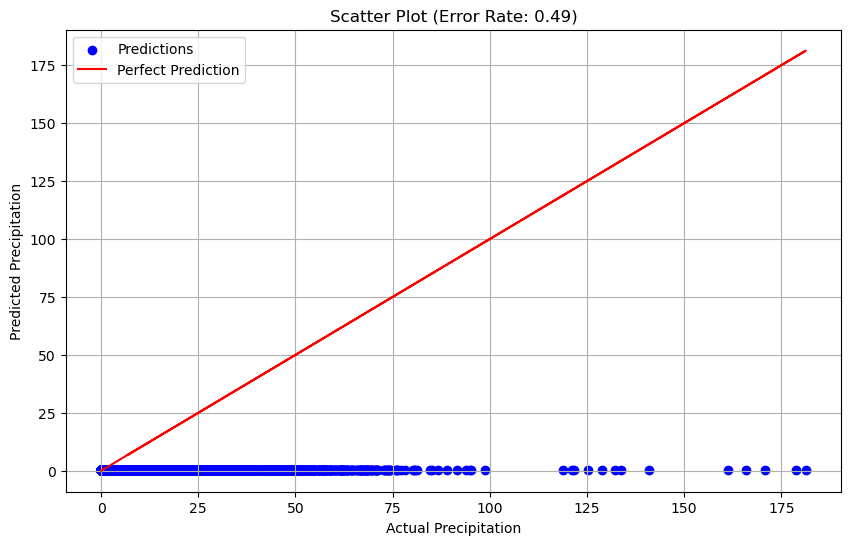

In [26]:
import matplotlib.pyplot as plt

# Function to plot scatter plot
def plot_scatter(predictions, actual, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predictions, color='blue', label='Predictions')
    plt.plot(actual, actual, color='red', label='Perfect Prediction')
    plt.title(title)
    plt.xlabel('Actual Precipitation')
    plt.ylabel('Predicted Precipitation')
    plt.legend()
    plt.grid(True)
    plt.show()

# Extract predictions, actual values, and error rates
predictions = unseen_data_predictions[0]['predictions']  # Assuming there's only one prediction in the list
actual = df['precipitationCal'].values
error_rate = unseen_data_predictions[0]['miss_percentage'] / 100  # Convert percentage to rate

# Plot scatter plot for perfect prediction and error rate
plot_scatter(predictions, actual, f'Scatter Plot (Error Rate: {error_rate:.2f})')


In [39]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from joblib import dump

# Directory containing your CSV files
folder_path = '/Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2018/'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Batch size
batch_size = 10

# Shuffle the list of CSV files
import random
random.shuffle(csv_files)

# Calculate the index to split files into training and testing sets
split_index = int(len(csv_files) * 0.7)

# Training set and Testing set
train_files = csv_files[:split_index]
test_files = csv_files[split_index:]

# Initialize common columns with columns from the first CSV file
common_columns = set(pd.read_csv(os.path.join(folder_path, csv_files[0])).columns)

# Loop through each CSV file in the folder to find common columns
for csv_file in csv_files[1:]:
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    common_columns = common_columns.intersection(df.columns)
    
    # Check if common variables are less than 5, skip the batch
if len(common_columns) < 5:
    print(f"\nSkipping Batch {start_index // batch_size + 1} (Less than 5 common variables):")
    for file in batch_files:
      print(f"- {file}")
      continue

# Print the common variables found in all files
print("\nCommon Variables:")
print(common_columns)

# Initialize an empty set to store all unique columns
all_columns = set()

# Loop through each CSV file in the folder to find all unique columns
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    all_columns.update(df.columns)

# Find the uncommon variables
uncommon_variables = all_columns - common_columns

# Print the uncommon variables
print("\nUncommon Variables:")
print(uncommon_variables)

# Initialize an empty list to store the files in memory
files_in_memory = []

# Initialize the model
model = Lasso(alpha=0.1, max_iter=10000, random_state=42)

# Loop through each CSV file in the folder
for idx, csv_file in enumerate(csv_files):
    # Load the data from CSV file, keeping only the common columns
    df = pd.read_csv(os.path.join(folder_path, csv_file))[list(common_columns) + ['precipitationCal']]
    
    # Concatenate the data to the DataFrame
    if idx == 0:
        concatenated_data = df
    else:
        concatenated_data = pd.concat([concatenated_data, df], ignore_index=True)

    # Extract features (X) and target (y) from the data
    X = df.drop(columns=['precipitationCal'])
    y = df['precipitationCal']

    # Ensure y contains only one column
    if isinstance(y, pd.DataFrame):
        y = y.values.reshape(-1)
        y = y[:len(X)]
        #y = y.iloc[:, 0]

    # Fit the model on the new data
    model.fit(X, y)
    
    # Print old and new files
    print(f"Old files: {files_in_memory}")
    print(f"New file: {csv_file}")
    
    # Update files in memory
    files_in_memory.append(csv_file)

# Print all files in memory
print(f"All files in memory: {files_in_memory}")

# Extract features (X) and target (y) from concatenated data for test set
X_test = concatenated_data.drop(columns=['precipitationCal'])
y_test = concatenated_data['precipitationCal']

# Ensure y contains only one column
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values.reshape(-1)
    y_test = y_test[:len(X_test)]

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error for the testing set
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

# Save the trained model as a .pkl file
model_filename = 'Lasso_model.pkl'
dump(model, model_filename)
print(f"Model saved as {model_filename}")



Common Variables:
{'0945 IMG_TIR1', '0115 IMG_WV', '0715 IMG_TIR2', '1915 IMG_WV', '0645 IMG_WV', '1415 IMG_WV', '2045 IMG_WV', '1315 IMG_TIR1', '0145 IMG_TIR1', '2045 IMG_TIR1', '0045 IMG_TIR1', '1245 IMG_TIR2', '1715 IMG_WV', '1615 IMG_TIR2', '0045 IMG_WV', '2145 IMG_TIR1', '1115 IMG_TIR2', '2145 IMG_TIR2', '0115 IMG_TIR2', '1015 IMG_WV', '2245 IMG_TIR1', '2015 IMG_TIR2', '0945 IMG_TIR2', '2015 IMG_WV', '1145 IMG_TIR2', '0145 IMG_TIR2', '1515 IMG_TIR1', '0245 IMG_WV', '1515 IMG_WV', '0315 IMG_WV', '1815 IMG_TIR2', '2345 IMG_TIR2', '1645 IMG_WV', '1645 IMG_TIR1', '1445 IMG_WV', '1715 IMG_TIR1', '0215 IMG_TIR1', '0315 IMG_TIR1', '2315 IMG_TIR2', '0745 IMG_TIR1', '1045 IMG_TIR1', '1315 IMG_WV', '2215 IMG_WV', '1115 IMG_TIR1', 'latitude', '0345 IMG_WV', '1015 IMG_TIR1', '0145 IMG_WV', '0015 IMG_WV', '2345 IMG_WV', '2245 IMG_WV', '0345 IMG_TIR1', '1345 IMG_TIR1', '1415 IMG_TIR1', '0615 IMG_TIR2', '0445 IMG_TIR1', '1315 IMG_TIR2', '0245 IMG_TIR2', '2015 IMG_TIR1', '1115 IMG_WV', '0645 IMG

/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e+05, tolerance: 3.391e+02
  model = cd_fast.enet_coordinate_descent(


Old files: []
New file: interpolated_insat_on_imerg_20180109.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e+07, tolerance: 5.305e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180109.csv']
New file: interpolated_insat_on_imerg_20180103.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.092e+07, tolerance: 3.497e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180103.csv']
New file: interpolated_insat_on_imerg_20180101.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+07, tolerance: 4.108e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv']
New file: interpolated_insat_on_imerg_20180104.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e+06, tolerance: 7.978e+02
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180104.csv']
New file: interpolated_insat_on_imerg_20180108.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.325e+06, tolerance: 1.121e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180104.csv', 'interpolated_insat_on_imerg_20180108.csv']
New file: interpolated_insat_on_imerg_20180107.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.133e+06, tolerance: 2.539e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180104.csv', 'interpolated_insat_on_imerg_20180108.csv', 'interpolated_insat_on_imerg_20180107.csv']
New file: interpolated_insat_on_imerg_20180102.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e+07, tolerance: 4.834e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180104.csv', 'interpolated_insat_on_imerg_20180108.csv', 'interpolated_insat_on_imerg_20180107.csv', 'interpolated_insat_on_imerg_20180102.csv']
New file: interpolated_insat_on_imerg_20180105.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.866e+06, tolerance: 1.622e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180104.csv', 'interpolated_insat_on_imerg_20180108.csv', 'interpolated_insat_on_imerg_20180107.csv', 'interpolated_insat_on_imerg_20180102.csv', 'interpolated_insat_on_imerg_20180105.csv']
New file: interpolated_insat_on_imerg_20180106.csv
Old files: ['interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180104.csv', 'interpolated_insat_on_imerg_20180108.csv', 'interpolated_insat_on_imerg_20180107.csv', 'interpolated_insat_on_imerg_20180102.csv', 'interpolated_insat_on_imerg_20180105.csv', 'interpolated_insat_on_imerg_20180106.csv']
New file: interpolated_insat_on_imerg_20180110.csv
All files in memory: ['interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_in

/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.701e+05, tolerance: 4.996e+02
  model = cd_fast.enet_coordinate_descent(


In [40]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from joblib import dump

# Directory containing your CSV files
folder_path = '/Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2018/'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Batch size
batch_size = 10

# Shuffle the list of CSV files
import random
random.shuffle(csv_files)

# Loop through batches of CSV files
for start_index in range(0, len(csv_files), batch_size):
  batch_files = csv_files[start_index:start_index + batch_size]

  # Initialize common columns with columns from the first file in the batch
  common_columns = set(pd.read_csv(os.path.join(folder_path, batch_files[0])).columns)

  # Loop through each CSV file in the batch to find common columns
  for csv_file in batch_files[1:]:
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    common_columns = common_columns.intersection(df.columns)

  # Check if common variables are less than 5, skip the batch
  if len(common_columns) < 5:
    print(f"\nSkipping Batch {start_index // batch_size + 1} (Less than 5 common variables):")
    for file in batch_files:
      print(f"- {file}")
    continue

  # Print the common variables found in all files in this batch
  print(f"\nCommon Variables for Batch {start_index // batch_size + 1}:")
  print(common_columns)

  # Initialize an empty list to store all unique columns for this batch
  all_columns = set()

  # Loop through each CSV file in the batch to find all unique columns
  for csv_file in batch_files:
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    all_columns.update(df.columns)

  # Find the uncommon variables for this batch
  uncommon_variables = all_columns - common_columns

  # Print the uncommon variables for this batch
  print(f"\nUncommon Variables for Batch {start_index // batch_size + 1}:")
  print(uncommon_variables)

  # Initialize an empty list to store the files in memory for this batch
  files_in_memory = []

  # Initialize the model
  model = Lasso(alpha=0.1, max_iter=10000, random_state=42)

  # Loop through each CSV file in the batch
  for idx, csv_file in enumerate(batch_files):
    # Load the data from CSV file, keeping only the common columns
    df = pd.read_csv(os.path.join(folder_path, csv_file))[list(common_columns) + ['precipitationCal']]

    # Concatenate the data to the DataFrame
    if idx == 0:
      concatenated_data = df
    else:
      concatenated_data = pd.concat([concatenated_data, df], ignore_index=True)

    # Extract features (X) and target (y) from the data
    X = df.drop(columns=['precipitationCal'])
    y = df['precipitationCal']

    # Ensure y contains only one column
    if isinstance(y, pd.DataFrame):
      y = y.values.reshape(-1)
      y = y[:len(X)]

    # Fit the model on the new data
    model.fit(X, y)

    # Print old and new files
    print(f"Old files: {files_in_memory}")
    print(f"New file: {csv_file}")

    # Update files in memory for this batch
    files_in_memory.append(csv_file)

  # Print all files processed in this batch
  print(f"All files processed in Batch {start_index // batch_size + 1}: {files_in_memory}")

  # Extract features (X) and target (y) from concatenated data for test set
  X_test = concatenated_data.drop(columns=['precipitationCal'])
  y_test = concatenated_data['precipitationCal']

# Ensure y contains only one column
  if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values.reshape(-1)
        y_test = y_test[:len(X_test)]
        
# Make predictions on the test set
  y_pred = model.predict(X_test)

# Calculate the mean squared error for the testing set
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

# Save the trained model as a .pkl file
model_filename = 'Lasso_model.pkl'
dump(model, model_filename)
print(f"Model saved as {model_filename}")




Common Variables for Batch 1:
{'0945 IMG_TIR1', '0115 IMG_WV', '0715 IMG_TIR2', '1915 IMG_WV', '0645 IMG_WV', '1415 IMG_WV', '2045 IMG_WV', '1315 IMG_TIR1', '0145 IMG_TIR1', '2045 IMG_TIR1', '0045 IMG_TIR1', '1245 IMG_TIR2', '1715 IMG_WV', '1615 IMG_TIR2', '0045 IMG_WV', '2145 IMG_TIR1', '1115 IMG_TIR2', '2145 IMG_TIR2', '0115 IMG_TIR2', '1015 IMG_WV', '2245 IMG_TIR1', '2015 IMG_TIR2', '0945 IMG_TIR2', '2015 IMG_WV', '1145 IMG_TIR2', '0145 IMG_TIR2', '1515 IMG_TIR1', '0245 IMG_WV', '1515 IMG_WV', '0315 IMG_WV', '1815 IMG_TIR2', '2345 IMG_TIR2', '1645 IMG_WV', '1645 IMG_TIR1', '1445 IMG_WV', '1715 IMG_TIR1', '0215 IMG_TIR1', '0315 IMG_TIR1', '2315 IMG_TIR2', '0745 IMG_TIR1', '1045 IMG_TIR1', '1315 IMG_WV', '2215 IMG_WV', '1115 IMG_TIR1', 'latitude', '0345 IMG_WV', '1015 IMG_TIR1', '0145 IMG_WV', '0015 IMG_WV', '2345 IMG_WV', '2245 IMG_WV', '0345 IMG_TIR1', '1345 IMG_TIR1', '1415 IMG_TIR1', '0615 IMG_TIR2', '0445 IMG_TIR1', '1315 IMG_TIR2', '0245 IMG_TIR2', '2015 IMG_TIR1', '1115 IMG_WV

/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e+07, tolerance: 4.834e+03
  model = cd_fast.enet_coordinate_descent(


Old files: []
New file: interpolated_insat_on_imerg_20180105.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e+07, tolerance: 5.305e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180105.csv']
New file: interpolated_insat_on_imerg_20180103.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.092e+07, tolerance: 3.497e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180105.csv', 'interpolated_insat_on_imerg_20180103.csv']
New file: interpolated_insat_on_imerg_20180101.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e+05, tolerance: 3.391e+02
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180105.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv']
New file: interpolated_insat_on_imerg_20180109.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.325e+06, tolerance: 1.121e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180105.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180109.csv']
New file: interpolated_insat_on_imerg_20180107.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+07, tolerance: 4.108e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180105.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180107.csv']
New file: interpolated_insat_on_imerg_20180104.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.133e+06, tolerance: 2.539e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180105.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180107.csv', 'interpolated_insat_on_imerg_20180104.csv']
New file: interpolated_insat_on_imerg_20180102.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e+06, tolerance: 7.978e+02
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180105.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180107.csv', 'interpolated_insat_on_imerg_20180104.csv', 'interpolated_insat_on_imerg_20180102.csv']
New file: interpolated_insat_on_imerg_20180108.csv


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.866e+06, tolerance: 1.622e+03
  model = cd_fast.enet_coordinate_descent(


Old files: ['interpolated_insat_on_imerg_20180105.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180107.csv', 'interpolated_insat_on_imerg_20180104.csv', 'interpolated_insat_on_imerg_20180102.csv', 'interpolated_insat_on_imerg_20180108.csv']
New file: interpolated_insat_on_imerg_20180106.csv
Old files: ['interpolated_insat_on_imerg_20180105.csv', 'interpolated_insat_on_imerg_20180103.csv', 'interpolated_insat_on_imerg_20180101.csv', 'interpolated_insat_on_imerg_20180109.csv', 'interpolated_insat_on_imerg_20180107.csv', 'interpolated_insat_on_imerg_20180104.csv', 'interpolated_insat_on_imerg_20180102.csv', 'interpolated_insat_on_imerg_20180108.csv', 'interpolated_insat_on_imerg_20180106.csv']
New file: interpolated_insat_on_imerg_20180110.csv
All files processed in Batch 1: ['interpolated_insat_on_imerg_20180105.csv', 'interpolated_insat_on_imerg_20180103.csv', 'inte

/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.701e+05, tolerance: 4.996e+02
  model = cd_fast.enet_coordinate_descent(


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Create an empty Sequential model
model2017 = Sequential()

# Add layers to the model manually based on the configuration
model2017.add(LSTM(units=64, input_shape=(1, 90), activation='tanh', recurrent_activation='sigmoid', name='lstm_299'))
model2017.add(Dense(units=128, activation='relu', name='dense_598'))
model2017.add(Dense(units=1, activation='linear', name='dense_599'))

# Load the weights of the first model
model2017.load_weights('/Users/kunalpathak9826/Desktop/ISRO/Model/RNN_model2017.h5')

# Similarly, create an empty Sequential model for the second model (model2018)
model2018 = Sequential()
model2018.add(LSTM(units=64, input_shape=(1, 129), activation='tanh', recurrent_activation='sigmoid', name='lstm_228'))
model2018.add(Dense(units=128, activation='relu', name='dense_456'))
model2018.add(Dense(units=1, activation='linear', name='dense_457'))
model2018.load_weights('/Users/kunalpathak9826/Desktop/ISRO/Model/RNN_model2018.h5')

# Create a new model with the architecture of the first model
merged_model = Sequential([
    LSTM(units=64, input_shape=(1, 90), activation='tanh', recurrent_activation='sigmoid'),
    Dense(units=128, activation='relu'),
    Dense(units=1, activation='linear')
])

# Transfer weights from model2017 to merged_model
for layer in merged_model.layers:
    if layer.name in ['lstm_299', 'dense_598', 'dense_599']:
        weights = model2017.get_layer(layer.name).get_weights()
        layer.set_weights(weights)

# Transfer weights from model2018 to merged_model
for layer in merged_model.layers:
    if layer.name in ['lstm_228', 'dense_456', 'dense_457']:
        weights = model2018.get_layer(layer.name).get_weights()
        layer.set_weights(weights)

# Save the merged model
merged_model.save('/Users/kunalpathak9826/Desktop/ISRO/Model/merged_rnn_model.h5')


/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Directory containing your CSV files
folder_path = '/Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Batch size
batch_size = 34

# Function for timestamp comparison
def compare_timestamps(var1, var2):
    try:
        timestamp1 = int(var1.split("_")[0])
        timestamp2 = int(var2.split("_")[0])
    except ValueError:
        return False
    threshold = 1  # You can adjust this threshold as needed
    return abs(timestamp1 - timestamp2) <= threshold

# Function to load and preprocess data
def load_and_preprocess_data(folder_path):
    dfs = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            filepath = os.path.join(folder_path, filename)
            print(f"Loading data from: {filepath}")
            df = pd.read_csv(filepath)
            # Perform preprocessing (e.g., removing NaN values)
            df.dropna(inplace=True)
            print(f"Preprocessed data shape: {df.shape}")
            dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    print(f"Concatenated data shape: {data.shape}")
    return data

# Function to perform PCA
def perform_pca(data):
    print("Performing PCA...")
    scaler = StandardScaler()
    imputer = SimpleImputer(strategy='mean')
    data_imputed = imputer.fit_transform(data)
    scaled_data = scaler.fit_transform(data_imputed)
    pca = PCA(n_components=147)  # You can change the number of components as per your requirement
    pca_data = pca.fit_transform(scaled_data)
    print(f"Data shape after PCA: {pca_data.shape}")
    print("PCA completed.")
    return pca_data

# Initialize the model outside the loop
model = Sequential()
model.add(LSTM(64, input_shape=(1, 147)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))  # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')

# Loop through files in batches
concatenated_data = None 
for start_index in range(0, len(csv_files), batch_size):
    # Get current batch of files
    batch_files = csv_files[start_index:start_index + batch_size]

    # Load and preprocess data for this batch
    data = load_and_preprocess_data(folder_path)
    X = data.drop(columns=['precipitationCal'])
    y = data['precipitationCal']
    
    # Perform PCA
    pca_data = perform_pca(X)
    
    # Reshape X for LSTM input
    X = pca_data.reshape(pca_data.shape[0], 1, pca_data.shape[1])

    # Fit the model on the new data
    model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)
    
    # Append the processed data from this batch to concatenated_data
    concatenated_data = pd.concat([concatenated_data, data], ignore_index=True)
    
# After processing all batches, prepare and evaluate the test set
# Extract features (X_test) and target (y_test) from concatenated data
X_test = concatenated_data.drop(columns=['precipitationCal'])
y_test = concatenated_data['precipitationCal']

if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values.reshape(-1)
    y_test = y_test[:len(X_test)]

# Reshape X_test for LSTM input
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print expected error (ground truth)
print(f"\nExpected Error (Ground Truth):\n{y_test[-10:]}")

if np.isnan(y_test).any():
    # If NaN values are present, impute them
    imputer = SimpleImputer(strategy='mean')
    y_test_imputed = imputer.fit_transform(y_test.values.reshape(-1, 1))
    y_test = y_test_imputed.flatten()
    
# Check for NaN values in y_pred
if np.isnan(y_pred).any():
    # If NaN values are present, impute them
    imputer = SimpleImputer(strategy='mean')
    y_pred_imputed = imputer.fit_transform(y_pred)
    y_pred = y_pred_imputed.flatten()


# Calculate the mean squared error for the testing set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
percent_error = ((np.mean(y_test) -  rmse) / rmse) * 100
print(f"Mean Squared Error on Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on Test Set: {rmse:.4f}")
print(f"Percentage Error on Test Set: {percent_error:.2f}%")

# Save the trained model as a .h5 file
model_filename = 'RNN_model.h5'
model.save(model_filename)
print(f"Model saved as {model_filename}")


Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20170109.csv
Preprocessed data shape: (25000, 145)
Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20170108.csv
Preprocessed data shape: (25000, 148)
Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20190101.csv
Preprocessed data shape: (25000, 142)
Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20180104.csv
Preprocessed data shape: (25000, 145)
Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20180110.csv
Preprocessed data shape: (25000, 148)
Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20180105.csv
Preprocessed data shape: (25000, 142)
Loading data from: /Users/kunalpat

/Users/kunalpathak9826/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from joblib import dump


# Directory containing your CSV files
folder_path = '/Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Batch size
batch_size = 34

# Function for timestamp comparison
def compare_timestamps(var1, var2):
    try:
        timestamp1 = int(var1.split("_")[0])
        timestamp2 = int(var2.split("_")[0])
    except ValueError:
        return False
    threshold = 1  # You can adjust this threshold as needed
    return abs(timestamp1 - timestamp2) <= threshold

# Function to load and preprocess data
def load_and_preprocess_data(folder_path):
    dfs = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            filepath = os.path.join(folder_path, filename)
            print(f"Loading data from: {filepath}")
            df = pd.read_csv(filepath)
            # Perform preprocessing (e.g., removing NaN values)
            df.dropna(inplace=True)
            print(f"Preprocessed data shape: {df.shape}")
            dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    print(f"Concatenated data shape: {data.shape}")
    return data

# Function to perform PCA
def perform_pca(data):
    print("Performing PCA...")
    scaler = StandardScaler()
    imputer = SimpleImputer(strategy='mean')
    data_imputed = imputer.fit_transform(data)
    scaled_data = scaler.fit_transform(data_imputed)
    pca = PCA(n_components=147)  # You can change the number of components as per your requirement
    pca_data = pca.fit_transform(scaled_data)
    print(f"Data shape after PCA: {pca_data.shape}")
    print("PCA completed.")
    return pca_data

# Initialize the model outside the loop
model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters

# Loop through files in batches
concatenated_data = None 
for start_index in range(0, len(csv_files), batch_size):
    # Get current batch of files
    batch_files = csv_files[start_index:start_index + batch_size]

    # Load and preprocess data for this batch
    data = load_and_preprocess_data(folder_path)
    X = data.drop(columns=['precipitationCal'])
    y = data['precipitationCal']
    
    # Perform PCA
    pca_data = perform_pca(X)
    
    # Reshape X for LSTM input
    X = pca_data.reshape(pca_data.shape[0], 1, pca_data.shape[1])

    # Fit the model on the new data
    model.fit(X, y)
    
    # Append the processed data from this batch to concatenated_data
    concatenated_data = pd.concat([concatenated_data, data], ignore_index=True)
    
# After processing all batches, prepare and evaluate the test set
# Extract features (X_test) and target (y_test) from concatenated data
X_test = concatenated_data.drop(columns=['precipitationCal'])
y_test = concatenated_data['precipitationCal']

if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values.reshape(-1)
    y_test = y_test[:len(X_test)]

# Reshape X_test for LSTM input
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print expected error (ground truth)
print(f"\nExpected Error (Ground Truth):\n{y_test[-10:]}")

if np.isnan(y_test).any():
    # If NaN values are present, impute them
    imputer = SimpleImputer(strategy='mean')
    y_test_imputed = imputer.fit_transform(y_test.values.reshape(-1, 1))
    y_test = y_test_imputed.flatten()
    
# Check for NaN values in y_pred
if np.isnan(y_pred).any():
    # If NaN values are present, impute them
    imputer = SimpleImputer(strategy='mean')
    y_pred_imputed = imputer.fit_transform(y_pred)
    y_pred = y_pred_imputed.flatten()


# Calculate the mean squared error for the testing set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
percent_error = ((np.mean(y_test) -  rmse) / rmse) * 100
print(f"Mean Squared Error on Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on Test Set: {rmse:.4f}")
print(f"Percentage Error on Test Set: {percent_error:.2f}%")

# Save the trained model as a .h5 file
model_filename = 'RandomForest_model.pkl'
dump(model, model_filename)
print(f"Model saved as {model_filename}")


Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20170109.csv
Preprocessed data shape: (25000, 145)
Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20170108.csv
Preprocessed data shape: (25000, 148)
Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20190101.csv
Preprocessed data shape: (25000, 142)
Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20180104.csv
Preprocessed data shape: (25000, 145)
Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20180110.csv
Preprocessed data shape: (25000, 148)
Loading data from: /Users/kunalpathak9826/Desktop/ISRO/Data/Interpolated CSV/2050/interpolated_insat_on_imerg_20180105.csv
Preprocessed data shape: (25000, 142)
Loading data from: /Users/kunalpat

ValueError: Found array with dim 3. RandomForestRegressor expected <= 2.